In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
# For running interactive view cells ipywidgets is needed
# Please Install it with `pip install ipywidgets`
from ipywidgets import interact, fixed, widgets, interact_manual

## Utilities

> For showing matrix of number as an image

$\text{show} :=  (\text{matrix} \in ndarray) \implies \text{filter} \in PIL.Image.Image$
```python
# Interactive view in jupyter
show(imn)
# Explicit view open in new temporary window
show(imn).show()
# Save to new file
show(imn).save(file_name, quality=95) 
```
----------------------------
> For generating `Difference of Gaussian` filter with shape of expected

$\text{DoG} := (\sigma_1 \in {\Bbb R}, \sigma_2 \in {\Bbb R}, \text{shape} \in tuple) \implies \text{filter} \in ndarray$
```python
filter = DoG(1,2,(3,3))
```
----------------------------
> For generatign `Difference of Gaussian` based on v1 criteria mecanism (mechanistic_v1_model).

> $\lambda$ := wavelength

> $\theta$ := orientation

> $\sigma$ := standard deviation

> $\gamma$ := aspect ratio

$\text{Gabor} = (\lambda \in {\Bbb R}, \theta \in {\Bbb R}, \sigma \in {\Bbb R}, \gamma \in {\Bbb R}) \implies \text{filter} \in ndarray$
```python
filter = Gabor(1, 3.5, 5, 3, (5,5))
```
----------------------------
> For generatign `Difference of Gaussian` based on v1 criteria mecanism

$\text{covolution_pass} = (\text{img} \in ndarray, \text{filter} \in ndarray) \implies \text{result} \in ndarray$
-----------------------------
> Zero padding and expand a filter to a bigger one
$\text{padding} = (\text{filter} \in ndarray, shape \in tuple) \implies \text{filter} \in ndarray$
```python
filter_9x9 = padding(filter_3x3, (9,9))
```
-----------------------------
> Get feature map for multiple images
$\text{convolution} = (\text{images} \in tuple_{ndarray}, \text{filters} \in tuple_{ndarray}, check \in Boolean) \implies feature_map \in array_{ndarray}$

```python
imgs = (img1, img2, img3, ...img_c)
# img1.shape = (wi, hi)

filters = (filter1, filter2, filter3 ... filter_n)
# filter1.shape = (wf, hf)

feature_map = convolution(imgs, filters)
# feature_map = [ndarray1(wi-wf+1, hi-hf+1, n)), ... ndarray_m(wi-wf+1, hi-hf+1, n)),]
```


In [2]:
def show(ndarray_mat, mode=None):
    return Image.fromarray(ndarray_mat.astype(np.uint8))    

In [3]:
# https://gist.github.com/amirHossein-Ebrahimi/6614d7a532d6fc65afd8dcd6056d58ea
def DoG(σ1, σ2, shape): 
    if (σ1 == 0 or σ2 == 0):
        print("WARNING: Result Filter gonna be all zero. σ1 and σ2 must be non zero")
        return np.zeros(shape)
    def _(x, y):
        xy_exp = -0.5 * ((x-(shape[0]//2))**2 + (y-(shape[1]//2))**2)
        return (np.exp(xy_exp/σ1**2)/σ1 - np.exp(xy_exp/σ2**2)/σ2) / np.sqrt(2 * np.pi)
    return np.fromfunction(_, shape)

In [4]:
def Gabor(λ, θ, σ, γ, shape):
    if (λ == 0 or σ == 0):
        print("WARNING: Result Filter gonna be all zero. λ and σ must be non zero")
        return np.zeros(shape)
    y, x = np.meshgrid(np.arange(-shape[0]//2+1, shape[0]//2+1), 
                       np.arange(-shape[1]//2+1, shape[1]//2+1))
    
    X = x*np.cos(θ) + y*np.sin(θ)
    γ2Y2 = γ**2 * (-x*np.sin(θ) + y*np.cos(θ))**2

    return np.exp(-0.5 * (X**2 + γ2Y2)/σ**2)* np.cos(2*np.pi/λ * X)

In [5]:
def padding(filter_mat, shape):
    assert len(shape) == 2, 'Only 2D Filter are supportted'
    assert shape[0] == shape[1], 'Only Square Filter are supportted'
    assert shape[0] % 2 == 1, 'Only Even filter are accepted'
    assert filter_mat.shape[0] < shape[0], 'Only Exapnssions are supported'
    res = np.zeros(shape)
    res[(shape[0]-filter_mat.shape[0]) // 2:(shape[0]+filter_mat.shape[0]) // 2,
        (shape[1]-filter_mat.shape[1]) // 2:(shape[1]+filter_mat.shape[1]) // 2] = filter_mat
    return res

In [6]:
def covolution_pass(img, filter_mat):
    filter_size =  filter_mat.shape[0]
    res = np.zeros((img.shape[0]-filter_size+1, img.shape[1]-filter_size+1))

    for y in range(img.shape[0]-filter_size+1):
        for x in range( img.shape[1]-filter_size+1):
            img_view = img[y:y+filter_size, x:x+filter_size, ...]
            res[y,x] = np.sum(img_view * filter_mat)
    return res

In [7]:
def convolution(imgs, filters, check=True):
    if check:
        check_convolution([img.shape for img in imgs],
                          [kerner.shape for kerner in filters])
    
    (wi, hi, *shape) = imgs[0].shape
    (wf, hf, *shape) = filters[0].shape
    shape = (wi-wf+1,hi-hf+1, len(filters))
    
    feature_maps = [np.empty(shape) for i in range(len(imgs))]
    for img_index, img in enumerate(imgs):
        for kernel_index, kernel in enumerate(filters):
            feature_maps[img_index][...,kernel_index] = covolution_pass(img, kernel)
    return feature_maps
    
# TODO: Implement with check depth can return in sonner version
def check_convolution(imgs, filters):
    assert len(set(imgs)) == 1, 'All of images must have same shape, make sure thry are same image or feature_map'
    
    assert len(set(filters)) == 1, 'All of filers must have same shape'

    img, kernel = imgs[0], filters[0]

    assert len(img) > 1 and len(kernel) > 1, 'No 1D array or less are expected as filter or image'
    assert len(img) < 4 and len(kernel) < 4, 'No 4D array or more are expected as filter or image'

    assert kernel[0] == kernel[1], 'Kernel must be in square shape for axis=[0,1] (2k+1, 2k+1, d)'

    assert kernel[0] % 2 == 1, 'Kernel must be in odd shape for axis=[0,1] (2k+1, 2k+1, d)'

    assert len(img) == 2 == len(kernel) or img[-1] == kernel[-1], "filter kernel don't match with images"

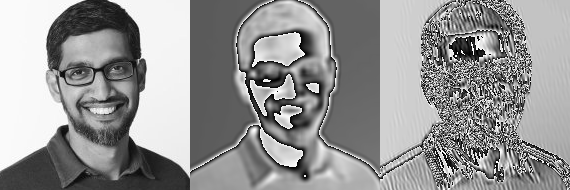

In [8]:
sundar_pichai = Image.open('../../assets/05/sundarpichai.jpg').convert('L')
imn = np.array(sundar_pichai, 'f')
filter_shape = (11,11)

# DoG
DoG_filter = DoG(8,3.5,filter_shape)
imn_with_DoG = covolution_pass(imn, DoG_filter).astype(np.uint8)
# Gabor
MV1M_filter = Gabor(4, 5,6, 1, filter_shape)
imn_with_MV1M = covolution_pass(imn, MV1M_filter).astype(np.uint8)
# Identity
identity_filter = padding(np.ones((1,1)), filter_shape)
imn_identity = covolution_pass(imn, identity_filter).astype(np.uint8)

show(np.concatenate((imn_identity, imn_with_DoG, imn_with_MV1M), axis=1))

(-0.5, 395.5, 197.5, -0.5)

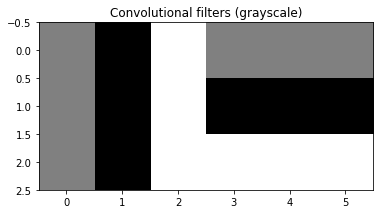

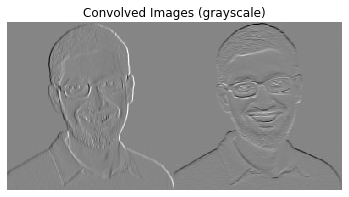

In [9]:
# nzp = negative zero positive
nzp_v, nzp_h = np.meshgrid(np.array([0,-1,1]), np.array([0,-1,1]))
plt.figure(1)
plt.title('Convolutional filters (grayscale)')
plt.imshow(
    np.concatenate((nzp_v, nzp_h), axis=1),
    cmap='binary_r', 
    interpolation='nearest'
)

plt.figure(2)
plt.title('Convolved Images (grayscale)')
plt.imshow(
        np.concatenate((
            covolution_pass(imn, nzp_v),
            covolution_pass(imn, nzp_h)
        ), axis=1),
        cmap='binary_r', 
        interpolation='nearest'
    )
plt.axis('off')

## Interactive View Cells

In [10]:
@interact(
    σ1=widgets.FloatSlider(min=-10, max=10, step=0.5, value=1), 
    σ2=widgets.FloatSlider(min=-10, max=10, step=0.5, value=1.8),
    size=[3,5,7,9,11],
    padd=[0,2,4]
)
def plotter(σ1, σ2, size, padd):
    DoG_filter = DoG(σ1=σ1,σ2=σ2, shape=(size,size))
    if (padd != 0):
        DoG_filter = padding(DoG_filter, shape=(size+padd, size+padd))
    plt.imshow(
        DoG_filter, 
        cmap='binary_r', 
        interpolation='nearest'
    )

interactive(children=(FloatSlider(value=1.0, description='σ1', max=10.0, min=-10.0, step=0.5), FloatSlider(val…

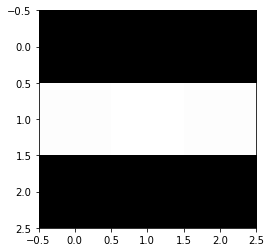

In [11]:
@interact(
    wave_length=widgets.FloatSlider(min=-4, max=4, step=0.1, value=3.1), 
    orientation=widgets.FloatSlider(min=-180, max=180, step=1, value=0),
    standard_deviation=widgets.FloatSlider(min=-10, max=10, step=0.5, value=6.5),
    aspect_ratio=widgets.FloatSlider(min=0, max=10, step=0.5, value=1),
    size=[3,5,7,9,11],
    padd=[0,2,4]
)
def plotter(wave_length, orientation, standard_deviation, aspect_ratio, size, padd):
    mv1_filter = Gabor(λ=wave_length, 
                        θ=orientation * np.pi / 180, 
                        σ=standard_deviation, 
                        γ=aspect_ratio, 
                        shape=(size, size))
    if (padd != 0):
        mv1_filter = padding(mv1_filter, shape=(size+padd, size+padd))
    plt.imshow(
        mv1_filter,
        cmap='binary_r', 
        interpolation='nearest'
    )

In [12]:
@interact_manual(
    sigma1=widgets.FloatSlider(min=0, max=100, step=0.5, value=15.5),
    sigma2=widgets.FloatSlider(min=0, max=100, step=0.5, value=15),
    wave_length=widgets.FloatSlider(min=-4, max=4, step=0.1, value=3.1), 
    orientation=widgets.FloatSlider(min=-180, max=180, step=1, value=45),    
    standard_deviation=widgets.FloatSlider(min=-10, max=10, step=0.5, value=6),
    aspect_ratio=widgets.FloatSlider(min=0, max=10, step=0.5, value=1),
    size=[3,5,7,9,11, 33],
    padd=[0,2,4]    
)
def mv1_plotter(wave_length, orientation, standard_deviation, aspect_ratio, size, padd, sigma1, sigma2):
    gabor_filter = Gabor(λ=wave_length, 
                        θ=orientation * np.pi / 180, 
                        σ=standard_deviation, 
                        γ=aspect_ratio, 
                        shape=(size, size))
                

    dog_filter = DoG(σ1=sigma1, σ2=sigma2, shape=(size, size))
    if (padd != 0):
        gabor_filter = padding(gabor_filter, shape=(size+padd, size+padd))  
        dog_filter = padding(dog_filter, shape=(size+padd, size+padd))  
    
    display(show(np.concatenate((covolution_pass(imn,gabor_filter), 
                                 covolution_pass(imn,dog_filter)), 
                                 axis=1)))

interactive(children=(FloatSlider(value=3.1, description='wave_length', max=4.0, min=-4.0), FloatSlider(value=…

## Feature maps

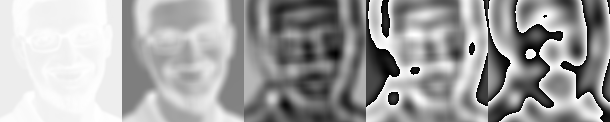

In [13]:
# DoG filters
filters = (
    padding(DoG(9,7.5,  (3,3)), (79,79)),
    padding(DoG(9,7.5,  (9,9)), (79,79)),
    padding(DoG(9,7.5,(27,27)), (79,79)),
    padding(DoG(9,7.5,(30,30)), (79,79)),
    DoG(9,7.5,                  (79,79)),
)
x = convolution((imn,), filters, False)
show(np.concatenate((x[0].transpose(2,0,1)), axis=1))

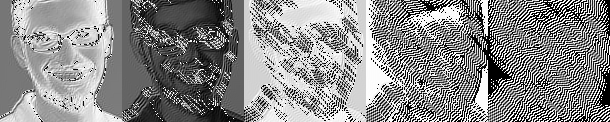

In [14]:
# Gabor filters
filters = (
    padding(Gabor(2.8,45*np.pi/180,-6.5,8,  (3,3)), (79,79)),
    padding(Gabor(2.8,45*np.pi/180,-6.5,8,  (9,9)), (79,79)),
    padding(Gabor(2.8,45*np.pi/180,-6.5,8,(15,15)), (79,79)),
    padding(Gabor(2.8,45*np.pi/180,-6.5,8,(20,20)), (79,79)),
    Gabor(2.8,45*np.pi/180,-6.5,8,                  (79,79)),
)
x = convolution((imn,), filters, False)
show(np.concatenate((x[0].transpose(2,0,1)), axis=1))